In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load dataset
df = pd.read_csv("synthetic_cbc_weekly_data.csv", parse_dates=["Timestamp"], index_col="Timestamp")

# Select multiple features for prediction
target_columns = ["RBC", "WBC", "HGB", "PLT"]
data = df[target_columns]

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Convert to DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=target_columns, index=df.index)


In [3]:
def create_sequences(data, look_back=4):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])  # Multi-output (RBC, WBC, HGB, PLT)
    return np.array(X), np.array(y)

# Define look-back period (4 weeks)
look_back = 4

# Create sequences
X, y = create_sequences(data_scaled.values, look_back)

# Split into train and test sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(target_columns)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(target_columns)))

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (796, 4, 4) (796, 4)
Testing data shape: (200, 4, 4) (200, 4)


In [4]:
# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, len(target_columns))),  
    LSTM(50, return_sequences=False),  
    Dense(25),
    Dense(len(target_columns))  # Output layer for 4 values
])

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.1466 - val_loss: 0.0869
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0841 - val_loss: 0.0897
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0861 - val_loss: 0.0878
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0837 - val_loss: 0.0847
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0841 - val_loss: 0.0874
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0837 - val_loss: 0.0862
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0881 - val_loss: 0.0896
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0852 - val_loss: 0.0838
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0828 - val_loss: 0.0863
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0817 - val_loss: 0.0840
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0845 - val_loss: 0.0846
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

In [5]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
y_train_actual = scaler.inverse_transform(y_train)

testPredict = scaler.inverse_transform(testPredict)
y_test_actual = scaler.inverse_transform(y_test)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


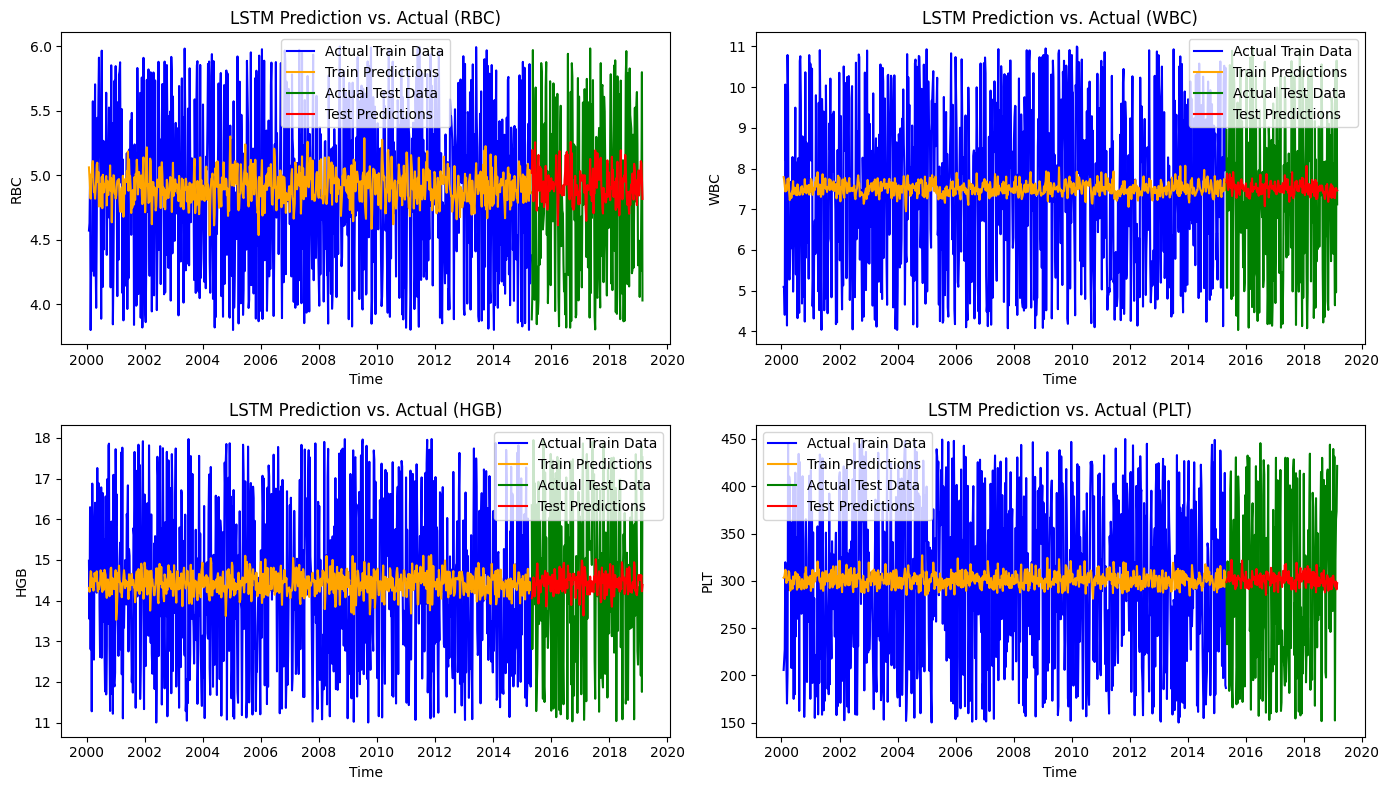

In [6]:
plt.figure(figsize=(14, 8))

for i, col in enumerate(target_columns):
    plt.subplot(2, 2, i+1)
    plt.plot(df.index[look_back:split+look_back], y_train_actual[:, i], label="Actual Train Data", color="blue")
    plt.plot(df.index[look_back:split+look_back], trainPredict[:, i], label="Train Predictions", color="orange")

    plt.plot(df.index[split+look_back:], y_test_actual[:, i], label="Actual Test Data", color="green")
    plt.plot(df.index[split+look_back:], testPredict[:, i], label="Test Predictions", color="red")

    plt.xlabel("Time")
    plt.ylabel(col)
    plt.title(f"LSTM Prediction vs. Actual ({col})")
    plt.legend()

plt.tight_layout()
plt.show()


In [7]:
from sklearn.metrics import mean_squared_error

for i, col in enumerate(target_columns):
    train_rmse = np.sqrt(mean_squared_error(y_train_actual[:, i], trainPredict[:, i]))
    test_rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], testPredict[:, i]))
    
    print(f"{col} - Train RMSE: {train_rmse:.2f}")
    print(f"{col} - Test RMSE: {test_rmse:.2f}")


RBC - Train RMSE: 0.61
RBC - Test RMSE: 0.66
WBC - Train RMSE: 2.04
WBC - Test RMSE: 2.03
HGB - Train RMSE: 1.95
HGB - Test RMSE: 2.00
PLT - Train RMSE: 86.59
PLT - Test RMSE: 89.27
